In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Let's try to do our best with a few ML model

In [3]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls


In [4]:
sklearn.__version__

'0.20.2'

In [5]:
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier,
                              GradientBoostingClassifier, ExtraTreesClassifier)

from sklearn.model_selection import KFold

## Data Preparation

We use the data preparation explained in the notebook called "Data Preparation for our studies "


import pandas as pd
import numpy as np
from transplant.config import *

df = pd.read_csv(PATH_STATIC_CLEAN)[STATIC_CATEGORIES['patient_intraoperative']]
declampage_col = list(df.filter(like='declampage_cote_2').columns)
declampage_col.append('id_patient')

X_intra=df[declampage_col].apply(pd.to_numeric, errors='coerce').dropna(1, how="all")

from transplant.data.dataset import Dataset
dataset = Dataset()

train, test = dataset.get_static()
X_train=train[['id_patient', 'target']]
X_test=test[['id_patient', 'target']]

X_train_intra_with_targ=pd.merge(X_train, X_intra, on='id_patient')
X_test_intra_with_targ=pd.merge(X_test, X_intra, on='id_patient')

mean_train = X_train_intra_with_targ.mean()

train_filled = X_train_intra_with_targ.fillna(mean_train)
test_filled = X_test_intra_with_targ.fillna(mean_train)



X_train = np.array(train_filled.drop(['target','id_patient'], axis=1))
X_test = np.array(test_filled.drop(['target','id_patient'], axis=1))
y_train = np.array(train_filled['target'])
y_test = np.array(test_filled['target'])
X_col = train_filled.drop(['target','id_patient'], axis=1).columns

def armand_funct():
    """
    How to : X_train, X_test, y_train ,Y_test, col = armand_funct()
    """
    from transplant.data.dataset import Dataset
    
    
    # To get Target
    dataset = Dataset()

    train, test = dataset.get_static()
    train['is_train'] = 1
    test['is_train'] = 0
    all_stat = pd.concat([train, test])
    all_stat = all_stat[['id_patient', 'target', 'is_train']].copy()
    
    # Intra
    df = pd.read_csv(PATH_STATIC_CLEAN)[STATIC_CATEGORIES['patient_intraoperative']]
    declampage = list(df.filter(like='declampage_cote_2').columns)
    declampage.append('id_patient')
    df = df[declampage]
    
    # Intra Num
    df_num = df.apply(pd.to_numeric, errors='coerce')
    
    # Merge with all_statto get target 
    df_num = df_num.merge(all_stat, on='id_patient')
    
    # Feature engi
    df_num['nb_nan_feature'] = pd.isnull(df_num).sum(axis=1)
    
    df_num = df_num.fillna(-99) # 
    
    
    # Split 
    
    y_train = np.array(df_num[df_num['is_train'] == 1]['target'])
    y_test = np.array(df_num[df_num['is_train'] == 0]['target'])
    
    X_train = df_num[df_num['is_train'] == 1].drop(['target', 'id_patient', 'is_train'], axis=1)
    X_test = df_num[df_num['is_train'] == 0].drop(['target', 'id_patient', 'is_train'], axis=1)
    col = X_train.columns
    
    return X_train.values, X_test.values, y_train ,y_test, col

In [6]:
from transplant.data.learningset import Learningset
#from transplant.config import *
learningset = Learningset()

#X_train, X_test, y_train, y_test, X_col = learningset.get_static_filled(to_train=True)
#X_train, X_test, y_train, y_test, X_col = learningset.get_data_merged_dynamic_flatten_full("cls", False)
#X_train, X_test, y_train, y_test, X_col = armand_funct()

train, test = learningset.get_data_merged_dynamic_flatten_full(full_df=True)

Choix des features : 

In [7]:
## RFE avec 4 modèles d'ensemble
choix_features_1=['PEEPtotal_std',
 'Temp_mean',
 'ETCO2_mean',
 'FiO2_std',
 'LAS',
 'Poids',
 'SpO2_mean',
 'BIS SR_std']

## Variables Antoine avec perspective résultats RFE
choix_features_4=['FiO2_std','FiO2_mean',
                  'SpO2_mean','SpO2_std',
                  'PEEPtotal_mean',
                  'BIS SR_std',
                  'PAPsys_max','PAPsys_std',
                  'PASs_mean','PASm_max',
                  'LAS',
                  'FC_std'
                 ]

choix_features_5=set(choix_features_4 + choix_features_1)


choix_features_6=['B.I.S_std',
 'ETCO2_max',
 'ETCO2_mean',
 'FC_mean',
 'FR_max',
 'FR_mean',
 'FiO2_mean',
 'FiO2_std',
 'LAS',
 'PAPmoy_mean',
 'PAPsys_max',
 'PASd_mean',
 'PASs_mean',
 'PEEPtotal_mean',
 'PEEPtotal_std',
 'PF_donor',
 'Poids',
 'SpO2_std',
 'Temp_mean',
 'VT_max',
 'VT_std',
 'body_mass_index',
 'declampage_cote2_done_std',
 'oto_score']

choix_features_7=set(choix_features_4 + choix_features_6)

choix_features_8=['BMI_donor', 'LAS', 'PF_donor', 'Poids', 'Poids_donor', 'Taille', 'age',
       'body_mass_index', 'oto_score', 'start_operation_month',
       'start_operation_day', 'ends_operation_day', 'ETCO2_mean', 'FC_mean',
       'FR_mean', 'FiO2_mean', 'PAPdia_mean', 'PAPmoy_mean', 'PASd_mean',
       'PASs_mean', 'PEEPtotal_mean', 'PNIm_mean', 'PNIs_mean', 'Pmax_mean',
       'Pmean_mean', 'SpO2_mean', 'Temp_mean', 'VT_mean',
       'declampage_cote2_done_mean', 'B.I.S_std', 'ETCO2_std', 'FC_std',
       'FiO2_std', 'PAPmoy_std', 'PASd_std', 'PASm_std', 'PASs_std',
       'PEEPtotal_std', 'PNIs_std', 'Pmax_std', 'Pmean_std', 'SpO2_std',
       'SvO2 (m)_std', 'Temp_std', 'VT_std', 'declampage_cote2_done_std',
       'ETCO2_max', 'FR_max', 'PAPmoy_max', 'PAPsys_max', 'PASd_max',
       'PASm_max', 'PASs_max', 'PEEPtotal_max', 'PNId_max', 'PNIm_max',
       'Pmax_max', 'Pmean_max', 'Temp_max', 'VT_max']

choix_features_9=set(choix_features_4 + choix_features_8)

choix_features_10=['Poids', 'ends_operation_day', 'ETCO2_mean', 'PASs_mean',
       'PEEPtotal_mean', 'Pmax_mean', 'Pmean_mean', 'SpO2_mean', 'Temp_mean',
       'VT_mean', 'declampage_cote2_done_mean', 'PASd_std', 'VT_std',
       'PASm_max', 'Temp_max']

choix_features_11=set(choix_features_4 + choix_features_10)

In [8]:
Choix_Features=choix_features_8

In [9]:
len(Choix_Features)

60

In [10]:
X_train=train[Choix_Features].values 
X_test=test[Choix_Features].values
y_train=train['target'].values
y_test=test['target'].values

In [11]:
X_col=train[Choix_Features].columns

In [12]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((228, 60), (102, 60), (228,), (102,))

We need to change the y format in order to make our models work

In [13]:
y_train, y_test = y_train.reshape(-1, 1).ravel() , y_test.reshape(-1, 1).ravel()

In [14]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((228, 60), (102, 60), (228,), (102,))

## ML Tuning

In [15]:
cols = X_col  # On a besoin des colonnes pour plus tard
# On observe le grand X et pas le petit x ...

ntrain = X_train.shape[0]

ntest = X_test.shape[0]

seed_fix = 5                   # Pour reproduire les résultats

In [16]:
ntrain, ntest

(228, 102)

In [17]:
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)

    def fit(self, x, y):
        return self.clf.fit(x, y)

    def feature_importances(self, x, y):
        return self.clf.fit(x, y).feature_importances_

In [18]:
NFOLDS = 5
kf = KFold(n_splits=NFOLDS, random_state=seed_fix)


def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf.split(x_train)):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [19]:
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
    #'warm_start': True,
    # 'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features': 'sqrt',
    'verbose': 0
}

In [20]:
et_params = {
    'n_jobs': -1,
    'n_estimators': 500,
    # 'max_features': 0.5,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}

In [21]:
ada_params = {
    'n_estimators': 500,
    'learning_rate': 0.75
}

In [22]:
gb_params = {
    'n_estimators': 500,
    # 'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}

In [23]:
rf = SklearnHelper(clf=RandomForestClassifier, seed=seed_fix, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=seed_fix, params=et_params)
ada = SklearnHelper(clf=AdaBoostClassifier, seed=seed_fix, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingClassifier,
                   seed=seed_fix, params=gb_params)

In [24]:
X_train.shape, y_train.shape, X_test.shape

((228, 60), (228,), (102, 60))

## Learning zone

In [25]:
%%time
et_oof_train, et_oof_test = get_oof(
    et, X_train, y_train, X_test)  # Extra Trees
rf_oof_train, rf_oof_test = get_oof(
    rf, X_train, y_train, X_test)  # Random Forest
ada_oof_train, ada_oof_test = get_oof(
    ada, X_train, y_train, X_test)  # AdaBoost
gb_oof_train, gb_oof_test = get_oof(
    gb, X_train, y_train, X_test)  # Gradient Boost

print("I am done learning :D")

I am done learning :D
Wall time: 31.8 s


In [26]:
rf_feature = rf.feature_importances(X_train, y_train)
et_feature = et.feature_importances(X_train, y_train)
ada_feature = ada.feature_importances(X_train, y_train)
gb_feature = gb.feature_importances(X_train, y_train)

# On met plutot dans un dataFrame
feature_dataframe = pd.DataFrame({'features': cols,
                                  'Random Forest Importance des features': rf_feature,
                                  'Extra Trees Importance des features': et_feature,
                                  'AdaBoost Importance des features': ada_feature,
                                  'Gradient Boost Importance des features': gb_feature
                                  })

In [27]:
rf_pred = rf.predict(X_test)
et_pred = et.predict(X_test)
ada_pred = ada.predict(X_test)
gb_pred = gb.predict(X_test)

In [28]:
accu_comparaison={} ## To compare performances at the end

In [29]:
accu_comparaison

{}

## Résultats

#### For the ones who forgot : 

##### Compute the precision

The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.

The best value is 1 and the worst value is 0.

##### Compute the recall

The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.

The best value is 1 and the worst value is 0.

##### F1 score
The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal. The formula for the F1 score is:

F1 = 2 (precision recall) / (precision + recall)

The support is the number of occurrences of each class in y_true

### Random Forest

In [30]:
print("Accuracy :")
rf_accu=metrics.accuracy_score(y_test,rf_pred)
accu_comparaison['Random Forest']=rf_accu
print(rf_accu)

Accuracy :
0.7058823529411765


In [31]:
accu_comparaison

{'Random Forest': 0.7058823529411765}

In [32]:
print(metrics.classification_report(rf_pred, y_test))

              precision    recall  f1-score   support

           0       0.86      0.70      0.77        73
           1       0.49      0.72      0.58        29

   micro avg       0.71      0.71      0.71       102
   macro avg       0.68      0.71      0.68       102
weighted avg       0.76      0.71      0.72       102



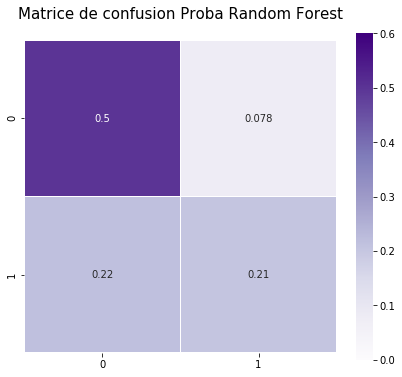

In [33]:
colormap = plt.cm.Purples
plt.figure(figsize=(7,6))
plt.title('Matrice de confusion Proba Random Forest', y=1.05, size=15)
sns.heatmap(confusion_matrix(y_test, rf_pred)/ntest,linewidths=0.1, 
            square=True, cmap=colormap, linecolor='white', annot=True,
           vmin=0, vmax=0.6)

In [34]:
trace = go.Scatter(x=feature_dataframe['features'].values,
                   y=feature_dataframe['Random Forest Importance des features'].values,

                   mode='markers',
                   marker=dict(
    sizemode='diameter',
    sizeref=1,
    size=25,
    # color = np.random.randn(500), #set color equal to a variable
    color=feature_dataframe['Random Forest Importance des features'].values,
    colorscale='Portland',
    showscale=True
),
    text=feature_dataframe['features'].values
)

data = [trace]

layout = go.Layout(
    autosize=True,
    title='Random Forest Importance des features',
    hovermode='closest',
    yaxis=dict(
        title='Importance des features',
        ticklen=5,
        gridwidth=2
    ),
    showlegend=False
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='scatter2010')

### Extra Tree

In [35]:
print("Accuracy :")
et_accu=metrics.accuracy_score(y_test,et_pred)
accu_comparaison['Extra Tree']=et_accu
print(et_accu)

Accuracy :
0.6470588235294118


In [36]:
print(metrics.classification_report(et_pred, y_test))

              precision    recall  f1-score   support

           0       0.90      0.64      0.75        83
           1       0.30      0.68      0.42        19

   micro avg       0.65      0.65      0.65       102
   macro avg       0.60      0.66      0.58       102
weighted avg       0.79      0.65      0.69       102



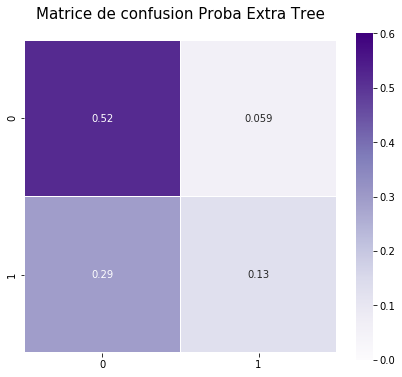

In [37]:
colormap = plt.cm.Purples
plt.figure(figsize=(7,6))
plt.title('Matrice de confusion Proba Extra Tree', y=1.05, size=15)
sns.heatmap(confusion_matrix(y_test, et_pred)/ntest,linewidths=0.1, 
            square=True, cmap=colormap, linecolor='white', annot=True,
           vmin=0, vmax=0.6)

In [38]:
trace = go.Scatter(
    y=feature_dataframe['Extra Trees Importance des features'].values,
    x=feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode='diameter',
        sizeref=1,
        size=25,
        color=feature_dataframe['Extra Trees Importance des features'].values,
        colorscale='Portland',
        showscale=True
    ),
    text=feature_dataframe['features'].values
)
data = [trace]

layout = go.Layout(
    autosize=True,
    title='Extra Trees Importance des features',
    hovermode='closest',

    yaxis=dict(
        title='Importance des features',
        ticklen=5,
        gridwidth=2
    ),
    showlegend=False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='scatter2010')

### Ada Boost

In [39]:
print("Accuracy :")
ada_accu=metrics.accuracy_score(y_test,ada_pred)
accu_comparaison['Ada Boost']=ada_accu
print(ada_accu)

Accuracy :
0.6176470588235294


In [40]:
print(metrics.classification_report(ada_pred, y_test))

              precision    recall  f1-score   support

           0       0.66      0.67      0.67        58
           1       0.56      0.55      0.55        44

   micro avg       0.62      0.62      0.62       102
   macro avg       0.61      0.61      0.61       102
weighted avg       0.62      0.62      0.62       102



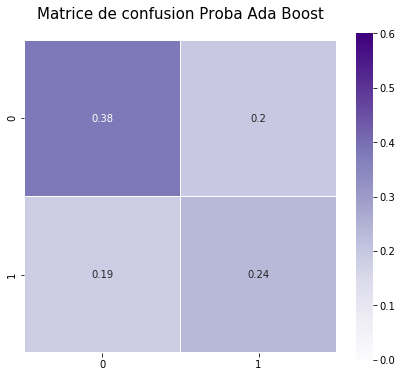

In [41]:
colormap = plt.cm.Purples
plt.figure(figsize=(7,6))
plt.title('Matrice de confusion Proba Ada Boost', y=1.05, size=15)
sns.heatmap(confusion_matrix(y_test, ada_pred)/ntest,linewidths=0.1, 
            square=True, cmap=colormap, linecolor='white', annot=True,
           vmin=0, vmax=0.6)

In [42]:
trace = go.Scatter(
    y=feature_dataframe['AdaBoost Importance des features'].values,
    x=feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode='diameter',
        sizeref=1,
        size=25,
        color=feature_dataframe['AdaBoost Importance des features'].values,
        colorscale='Portland',
        showscale=True
    ),
    text=feature_dataframe['features'].values
)
data = [trace]

layout = go.Layout(
    autosize=True,
    title='AdaBoost Importance des features',
    hovermode='closest',
    yaxis=dict(
        title='Importance des features',
        ticklen=5,
        gridwidth=2
    ),
    showlegend=False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='scatter2010')

### Gradient Boost

In [43]:
print("Accuracy :")
gb_accu=metrics.accuracy_score(y_test,gb_pred)
accu_comparaison['Gradient Boost']=gb_accu
print(gb_accu)

Accuracy :
0.6470588235294118


In [44]:
print(metrics.classification_report(gb_pred, y_test))

              precision    recall  f1-score   support

           0       0.71      0.69      0.70        61
           1       0.56      0.59      0.57        41

   micro avg       0.65      0.65      0.65       102
   macro avg       0.64      0.64      0.64       102
weighted avg       0.65      0.65      0.65       102



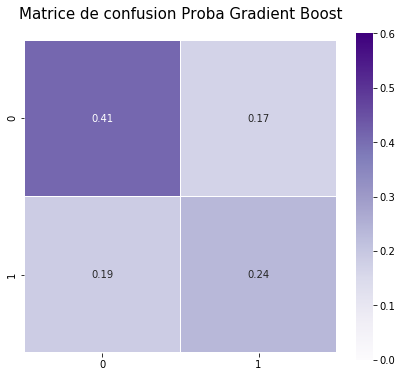

In [45]:
colormap = plt.cm.Purples
plt.figure(figsize=(7,6))
plt.title('Matrice de confusion Proba Gradient Boost', y=1.05, size=15)
sns.heatmap(confusion_matrix(y_test, gb_pred)/ntest,linewidths=0.1, 
            square=True, cmap=colormap, linecolor='white', annot=True,
           vmin=0, vmax=0.6)

In [46]:
trace = go.Scatter(
    y=feature_dataframe['Gradient Boost Importance des features'].values,
    x=feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode='diameter',
        sizeref=1,
        size=25,
        color=feature_dataframe['Gradient Boost Importance des features'].values,
        colorscale='Portland',
        showscale=True
    ),
    text=feature_dataframe['features'].values
)
data = [trace]

layout = go.Layout(
    autosize=True,
    title='Gradient Boosting Importance des features',
    hovermode='closest',
    yaxis=dict(
        title='Importance des features',
        ticklen=5,
        gridwidth=2
    ),
    showlegend=False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='scatter2010')

## Stacking 

In [47]:
feature_dataframe['moyenne'] = feature_dataframe.mean(axis= 1) 
feature_dataframe.head(5)

,features,Random Forest Importance des features,Extra Trees Importance des features,AdaBoost Importance des features,Gradient Boost Importance des features,moyenne
0,BMI_donor,0.012559,0.015497,0.028,0.021625,0.019420
1,LAS,0.017538,0.032761,0.060,0.045951,0.039063
2,PF_donor,0.016881,0.014837,0.024,0.003211,0.014732
3,Poids,0.028739,0.026283,0.024,0.027679,0.026675
4,Poids_donor,0.009100,0.013462,0.008,0.013885,0.011112


In [48]:
trace = go.Scatter(
    y=feature_dataframe['moyenne'].values,
    x=feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode='diameter',
        sizeref=1,
        size=25,
        color=feature_dataframe['moyenne'].values,
        colorscale='Portland',
        showscale=True
    ),
    text=feature_dataframe['features'].values
)
data = [trace]

layout = go.Layout(
    autosize=True,
    title="Moyenne de l'importance des features",
    hovermode='closest',
    yaxis=dict(
        title='Importance des features',
        ticklen=5,
        gridwidth=2
    ),
    showlegend=False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='scatter2010')

In [49]:
premieres_predictions_train = pd.DataFrame( {'RandomForest': rf_oof_train.ravel(),
     'ExtraTrees': et_oof_train.ravel(),
     'AdaBoost': ada_oof_train.ravel(),
      'GradientBoost': gb_oof_train.ravel()
    })
premieres_predictions_train.head()

,RandomForest,ExtraTrees,AdaBoost,GradientBoost
0,1.0,1.0,0.0,1.0
1,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0


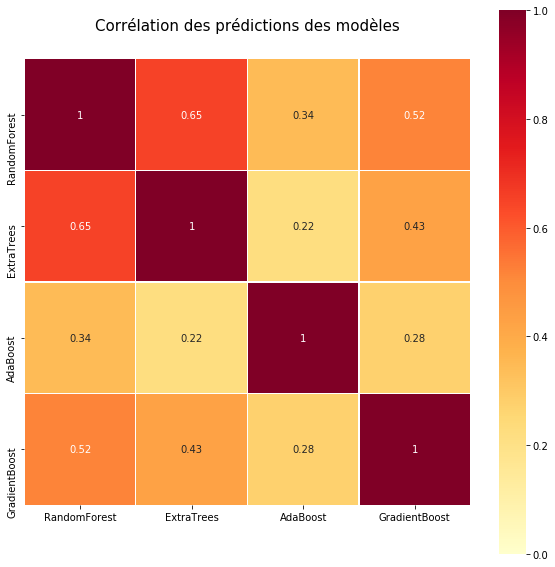

In [50]:
colormap = plt.cm.YlOrRd
plt.figure(figsize=(10,10))
plt.title('Corrélation des prédictions des modèles', y=1.05, size=15)
sns.heatmap(premieres_predictions_train.astype(float).corr().values, linewidths=0.1, 
            square=True, cmap=colormap, linecolor='white', annot=True,
           vmin=0, vmax=1,
           xticklabels=premieres_predictions_train.columns.values, yticklabels=premieres_predictions_train.columns.values)

In [51]:
x_train_stack = np.concatenate(( et_oof_train, rf_oof_train, ada_oof_train, gb_oof_train), axis=1)
x_test_stack = np.concatenate(( et_oof_test, rf_oof_test, ada_oof_test, gb_oof_test), axis=1)

### GradientBoosting Stack

In [52]:
GBC_stck=GradientBoostingClassifier()

In [53]:
GBC_stck.fit(x_train_stack,y_train)
y_test_GBC_stack=GBC_stck.predict(x_test_stack)

In [54]:
print("Accuracy :")
GBC_stack_accu=metrics.accuracy_score(y_test,y_test_GBC_stack)
accu_comparaison['Gradient Boosting Stacked']=GBC_stack_accu
print(GBC_stack_accu)

Accuracy :
0.7254901960784313


In [55]:
print(metrics.classification_report(y_test,y_test_GBC_stack))

              precision    recall  f1-score   support

           0       0.70      0.93      0.80        59
           1       0.83      0.44      0.58        43

   micro avg       0.73      0.73      0.73       102
   macro avg       0.76      0.69      0.69       102
weighted avg       0.75      0.73      0.70       102



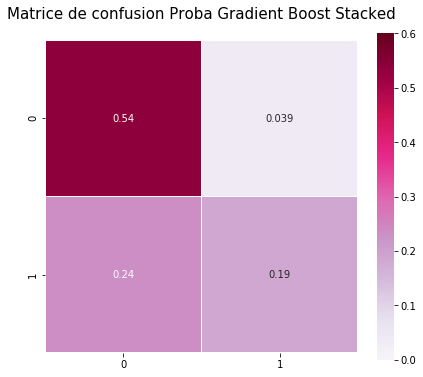

In [56]:
colormap = plt.cm.PuRd
plt.figure(figsize=(7,6))
plt.title('Matrice de confusion Proba Gradient Boost Stacked', y=1.05, size=15)
sns.heatmap(confusion_matrix(y_test,y_test_GBC_stack)/ntest,linewidths=0.1, 
            square=True, cmap=colormap, linecolor='white', annot=True,
           vmin=0, vmax=0.6)

### Random Forest Stack

In [57]:
RF_stck=RandomForestClassifier()

In [58]:
RF_stck.fit(x_train_stack,y_train)
y_test_RF_stack=RF_stck.predict(x_test_stack)

In [59]:
print("Accuracy :")
RF_stack_accu=metrics.accuracy_score(y_test,y_test_RF_stack)
accu_comparaison['Random Forest Stacked']=RF_stack_accu
print(RF_stack_accu)

Accuracy :
0.6568627450980392


In [60]:
print(metrics.classification_report(y_test,y_test_RF_stack))

              precision    recall  f1-score   support

           0       0.68      0.78      0.72        59
           1       0.62      0.49      0.55        43

   micro avg       0.66      0.66      0.66       102
   macro avg       0.65      0.63      0.63       102
weighted avg       0.65      0.66      0.65       102



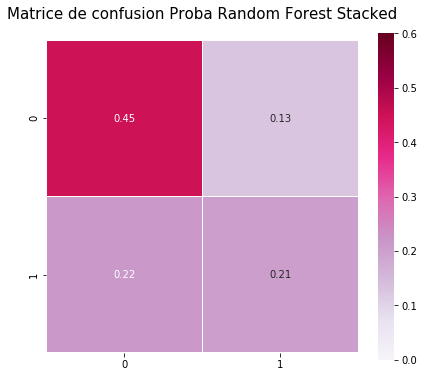

In [61]:
colormap = plt.cm.PuRd
plt.figure(figsize=(7,6))
plt.title('Matrice de confusion Proba Random Forest Stacked', y=1.05, size=15)
sns.heatmap(confusion_matrix(y_test,y_test_RF_stack)/ntest,linewidths=0.1, 
            square=True, cmap=colormap, linecolor='white', annot=True,
           vmin=0, vmax=0.6)

## Comparaison Résultats

In [62]:
accu_comparaison

{'Random Forest': 0.7058823529411765,
 'Extra Tree': 0.6470588235294118,
 'Ada Boost': 0.6176470588235294,
 'Gradient Boost': 0.6470588235294118,
 'Gradient Boosting Stacked': 0.7254901960784313,
 'Random Forest Stacked': 0.6568627450980392}

In [63]:
accu_comparaison_df=pd.DataFrame(accu_comparaison,index=[0])

In [64]:
index_asc=accu_comparaison_df.values.ravel().argsort().argsort()
index_asc

array([4, 1, 0, 2, 5, 3], dtype=int64)

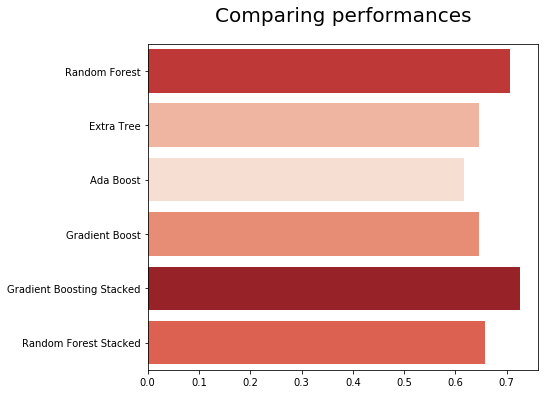

In [65]:
plt.figure(figsize=(7,6))
plt.title('Comparing performances', y=1.05, size=20)
sns.barplot(accu_comparaison_df.values.ravel(),
            accu_comparaison_df.columns,
            palette=np.array((sns.color_palette("Reds", n_colors=len(index_asc))))[list(index_asc)])

In [66]:
accu_comparaison_df

,Random Forest,Extra Tree,Ada Boost,Gradient Boost,Gradient Boosting Stacked,Random Forest Stacked
0,0.705882,0.647059,0.617647,0.647059,0.72549,0.656863
